# GloVE

Let's work on implementation of GloVE.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

## Loading 'webtext' corpus from NLTK

In [2]:
import nltk
nltk.download("webtext")
from nltk.corpus import webtext

[nltk_data] Downloading package webtext to
[nltk_data]     /Users/sbasnyat/nltk_data...
[nltk_data]   Package webtext is already up-to-date!


In [3]:
raw_text = webtext.raw()
corpus = raw_text.split("\n")  # Split raw text into sentences based on newlines

In [4]:
print(len(corpus))

29071


In [5]:
print(corpus[1])

When in full screen mode


In [6]:
corpus_tokenized = [[word.lower() for word in sentence.split() if word.isalnum()]for sentence in corpus]

In [7]:
print(corpus_tokenized[:5])

[['cookie', 'allow', 'sites', 'that', 'set', 'removed', 'cookies', 'to', 'set', 'future', 'should', 'stay', 'checked'], ['when', 'in', 'full', 'screen', 'mode'], ['pressing', 'should', 'open', 'a', 'new', 'browser', 'when', 'only', 'download', 'dialog', 'is', 'left', 'open'], ['add', 'icons', 'to', 'context', 'menu'], ['so', 'called', 'should', 'be', 'made', 'a', 'proper', 'toolbar', 'or', 'given', 'the', 'ability', 'collapse']]


In [8]:
flatten = lambda l: [item for sublist in l for item in sublist]
vocab = list(set(flatten(corpus_tokenized)))

In [9]:
print("Sample vocabulary words:", vocab[:5])
print("Vocabulary size:", len(vocab))

Sample vocabulary words: ['cottage', 'independent', 'gaping', 'louis', 'untravelled']
Vocabulary size: 12888


In [10]:
#numericalization
word2index = {w: i for i, w in enumerate(vocab)}


In [11]:
#vocab size
voc_size = len(vocab)
print(voc_size)

12888


In [12]:
#append UNK
vocab.append("<UNK>")

In [13]:
word2index["<UNK>"] = 0

In [14]:
#just in case we need to use
index2word = {v:k for k, v in word2index.items()} 

## 2. Build Co-occurence Matrix X

Here, we need to count the co-occurence of two words given some window size.  We gonna use window size of 1.

In [15]:
from collections import Counter

X_i = Counter(flatten(corpus_tokenized)) # X_i
X_i

Counter({'the': 7733,
         'to': 6232,
         'a': 6072,
         'i': 6033,
         'you': 4530,
         'and': 4360,
         'in': 4131,
         'of': 3156,
         'on': 3114,
         'is': 2873,
         'not': 2551,
         'with': 1886,
         'that': 1882,
         'for': 1830,
         'when': 1809,
         'it': 1809,
         'girl': 1558,
         'my': 1534,
         'have': 1373,
         'but': 1356,
         'this': 1326,
         'be': 1273,
         'guy': 1201,
         'like': 1198,
         'was': 1186,
         'so': 1179,
         'are': 1167,
         'if': 1090,
         'just': 1015,
         'from': 987,
         'your': 976,
         'at': 942,
         'do': 914,
         'what': 912,
         'all': 895,
         'he': 881,
         'get': 841,
         'no': 817,
         'firefox': 808,
         'me': 807,
         'page': 782,
         'new': 752,
         'does': 742,
         'or': 705,
         'we': 695,
         'up': 683,
         '

In [16]:
def random_batch_skipgram(corpus, window_size = 2):
    skip_grams = []
    for sent in corpus:
        for i in range(1, len(sent) - 1):
            target = sent[i]
            context = []
            for j in range(window_size):
                if i - (j + 1) >= 0:  ## Checking  if out of range from left of list
                    context.append(sent[i - (j + 1)])
                if i + (j + 1) < len(sent): 
                    context.append(sent[i + (j + 1)])
            for w in context:
                skip_grams.append((target,w))
    return skip_grams

In [17]:
X_ik_skipgram = Counter(random_batch_skipgram(corpus, window_size = 3))

In [18]:
print(X_ik_skipgram)

Counter({('e', ' '): 150392, (' ', 'e'): 150336, ('o', ' '): 140725, (' ', 'o'): 140708, (' ', 't'): 118885, ('t', ' '): 118837, (' ', 'a'): 113753, ('a', ' '): 113724, (' ', ' '): 106613, (' ', 'n'): 102564, ('n', ' '): 102526, (' ', 'i'): 93755, ('i', ' '): 93748, ('s', ' '): 75395, (' ', 's'): 75362, ('h', ' '): 71060, (' ', 'h'): 71051, ('r', ' '): 70446, (' ', 'r'): 70414, ('e', 't'): 56187, ('t', 'e'): 56128, ('l', ' '): 54298, (' ', 'l'): 54276, ('e', 'r'): 51086, ('r', 'e'): 51041, (' ', 'u'): 51001, ('u', ' '): 50989, ('d', ' '): 49576, (' ', 'd'): 49563, ('e', 'e'): 46515, ('o', 't'): 44569, ('t', 'o'): 44524, ('e', 's'): 44029, ('s', 'e'): 43922, ('e', 'a'): 43363, ('a', 'e'): 43348, ('n', 'i'): 42433, ('i', 'n'): 42401, ('e', 'n'): 40330, ('n', 'e'): 40294, ('o', 'n'): 40200, ('n', 'o'): 40156, ('t', 'i'): 38769, ('i', 't'): 38758, ('t', 'a'): 37500, ('a', 't'): 37466, ('y', ' '): 37121, (' ', 'y'): 37108, ('t', 'n'): 36585, ('n', 't'): 36577, ('o', 'e'): 36493, ('e', 'o'):

### Weighting function

GloVe includes a weighting function to scale down too frequent words.

In [19]:
#simply a normalized function...don't worry too much
def weighting(w_i, w_j, X_ik):
        
    #check whether the co-occurrences exist between these two words
    try:
        x_ij = X_ik[(w_i, w_j)]
    except:
        x_ij = 1  #if does not exist, set it to 1
                
    x_max = 100 #100 # fixed in paper  #cannot exceed 100 counts
    alpha = 0.75
    
    #if co-occurrence does not exceed 100, scale it based on some alpha
    if x_ij < x_max:
        result = (x_ij/x_max)**alpha  #scale it
    else:
        result = 1  #if is greater than max, set it to 1 maximum
    
    return result

In [20]:
from itertools import combinations_with_replacement

X_ik = {}  #for keeping the co-occurences
weighting_dic = {} #scaling the percentage of sampling

for bigram in combinations_with_replacement(vocab, 2):
    if X_ik_skipgram.get(bigram) is not None:  #matches 
        co_occer = X_ik_skipgram[bigram]  #get the count from what we already counted
        X_ik[bigram] = co_occer + 1 # + 1 for stability issue
        X_ik[(bigram[1],bigram[0])] = co_occer+1   #count also for the opposite
    else:
        pass
        
    weighting_dic[bigram] = weighting(bigram[0], bigram[1], X_ik)
    weighting_dic[(bigram[1], bigram[0])] = weighting(bigram[1], bigram[0], X_ik)


## 3. Prepare train data

In [21]:
import math

def random_batch(batch_size, corpus,  X_ik, weighting_dic, window_size=2):
    
    #convert to id since our skip_grams is word, not yet id
    skip_grams = random_batch_skipgram(corpus, window_size)
    skip_grams_id = [(word2index[skip_gram[0]], word2index[skip_gram[1]]) for skip_gram in skip_grams]
    
    random_inputs = []
    random_labels = []
    random_coocs  = []
    random_weightings = []
    random_index = np.random.choice(range(len(skip_grams_id)), batch_size, replace=False) #randomly pick without replacement
        
    for i in random_index:
        random_inputs.append([skip_grams_id[i][0]])  # target, e.g., 2
        random_labels.append([skip_grams_id[i][1]])  # context word, e.g., 3
        
        #get cooc
        pair = skip_grams[i]
        try:
            cooc = X_ik[pair]
        except:
            cooc = 1
        random_coocs.append([math.log(cooc)])
        
        #get weighting
        weighting = weighting_dic[pair]
        random_weightings.append([weighting])
                    
    return np.array(random_inputs), np.array(random_labels), np.array(random_coocs), np.array(random_weightings)

### Testing the method

In [22]:
#testing the method
batch_size = 2 # mini-batch size
input_batch, target_batch, cooc_batch, weighting_batch = random_batch(batch_size, corpus_tokenized, X_ik, weighting_dic, window_size=3)

print("Input: ", input_batch)
print("Target: ", target_batch)
print("Cooc: ", cooc_batch)
print("Weighting: ", weighting_batch)

#we will convert them to tensor during training, so don't worry...

Input:  [[9093]
 [7522]]
Target:  [[9309]
 [ 860]]
Cooc:  [[0.]
 [0.]]
Weighting:  [[0.03162278]
 [0.03162278]]


## 4. Model

In [23]:
class GloVe(nn.Module):
    
    def __init__(self, vocab_size,embed_size):
        super(GloVe,self).__init__()
        self.embedding_v = nn.Embedding(vocab_size, embed_size) # center embedding
        self.embedding_u = nn.Embedding(vocab_size, embed_size) # out embedding
        
        self.v_bias = nn.Embedding(vocab_size, 1)
        self.u_bias = nn.Embedding(vocab_size, 1)
        
    def forward(self, center_words, target_words, coocs, weighting):
        center_embeds = self.embedding_v(center_words) # [batch_size, 1, emb_size]
        target_embeds = self.embedding_u(target_words) # [batch_size, 1, emb_size]
        
        center_bias = self.v_bias(center_words).squeeze(1)
        target_bias = self.u_bias(target_words).squeeze(1)
        
        inner_product = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, 1, emb_size] @ [batch_size, emb_size, 1] = [batch_size, 1, 1] = [batch_size, 1]
        
        #note that coocs already got log
        loss = weighting*torch.pow(inner_product +center_bias + target_bias - coocs, 2)
        
        return torch.sum(loss)

## 5. Training

In [24]:
batch_size = 8
embedding_size = 2  # So we can visualize embeddings later
num_epochs = 1000  # Number of epochs
learning_rate = 0.001

# Model, optimizer
model_GloVe = GloVe(voc_size, embedding_size)  # Initialize the GloVe model
optimizer = optim.Adam(model_GloVe.parameters(), lr=learning_rate)

In [25]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [26]:
import time

# Training
num_epochs = 500
for epoch in range(num_epochs):
    
    start = time.time()
    
    input_batch, target_batch, cooc_batch, weighting_batch = random_batch(batch_size, corpus_tokenized,  X_ik, weighting_dic, window_size=3)
    input_batch  = torch.LongTensor(input_batch)         #[batch_size, 1]
    target_batch = torch.LongTensor(target_batch)        #[batch_size, 1]
    cooc_batch   = torch.FloatTensor(cooc_batch)         #[batch_size, 1]
    weighting_batch = torch.FloatTensor(weighting_batch) #[batch_size, 1]
    
    optimizer.zero_grad()
    loss = model_GloVe(input_batch, target_batch, cooc_batch, weighting_batch)
    
    loss.backward()
    optimizer.step()
    
    end = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start, end)

    if (epoch + 1) % 100 == 0:
        print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {epoch_mins}m {epoch_secs}s")


Epoch: 100 | cost: 1.093335 | time: 0m 0s
Epoch: 200 | cost: 0.400777 | time: 0m 0s
Epoch: 300 | cost: 0.400146 | time: 0m 0s
Epoch: 400 | cost: 0.310894 | time: 0m 0s
Epoch: 500 | cost: 0.655882 | time: 0m 0s


## 6. Plotting the embeddings

In [105]:
#list of vocabs
vocab[:10]

['viewable',
 'fades',
 'identified',
 'bookmarsk',
 'drunkpants',
 'poping',
 'restrooms',
 'scruffy',
 'from',
 '09']

In [106]:
word = vocab[0]

In [107]:
#numericalization
id = word2index[word]
id

0

In [108]:
id_tensor = torch.LongTensor([id])
id_tensor

tensor([0])

In [109]:
#get the embedding by averaging
v_embed = model_GloVe.embedding_v(id_tensor)
u_embed = model_GloVe.embedding_u(id_tensor)

v_embed, u_embed

(tensor([[-0.9326, -0.1566]], grad_fn=<EmbeddingBackward0>),
 tensor([[ 0.9207, -1.9951]], grad_fn=<EmbeddingBackward0>))

In [110]:
#average to get the word embedding
word_embed = (v_embed + u_embed) / 2
word_embed[0][1]

tensor(-1.0758, grad_fn=<SelectBackward0>)

In [111]:
#let's write a function to get embedding given a word
def get_embed(word):
    id_tensor = torch.LongTensor([word2index[word]])
    v_embed = model_GloVe.embedding_v(id_tensor)
    u_embed = model_GloVe.embedding_u(id_tensor) 
    word_embed = (v_embed + u_embed) / 2 
    x, y = word_embed[0][0].item(), word_embed[0][1].item()

    return x, y

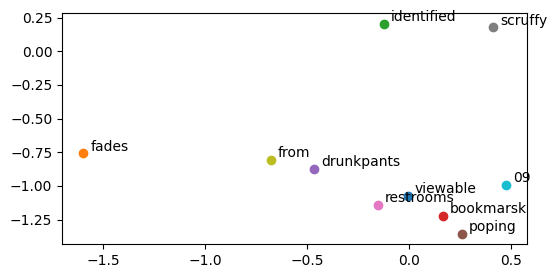

In [112]:
plt.figure(figsize=(6,3))
for i, word in enumerate(vocab[:10]): #loop each unique vocab
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

## 7. Cosine similarity

Formally the [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) $s$ between two vectors $p$ and $q$ is defined as:

$$s = \frac{p \cdot q}{||p|| ||q||}, \textrm{ where } s \in [-1, 1] $$ 

If $p$ and $q$ is super similar, the result is 1 otherwise 0.

In [113]:
vocab

['viewable',
 'fades',
 'identified',
 'bookmarsk',
 'drunkpants',
 'poping',
 'restrooms',
 'scruffy',
 'from',
 '09',
 'risky',
 'by',
 'suppose',
 'entirely',
 'xmms',
 'makes',
 '48th',
 'crushing',
 'claret',
 '89',
 'denver',
 'shove',
 'liquorice',
 'stressed',
 'htaccess',
 'hurrying',
 'geisha',
 'sox',
 'swinging',
 'sparring',
 'subtle',
 'technicolor',
 'intestines',
 'refuses',
 'mimic',
 'eccentric',
 'ocean',
 'male',
 'bone',
 'stable',
 'science',
 'intervention',
 'eensy',
 'shows',
 'scimitar',
 'regarding',
 'budding',
 'breed',
 'beckons',
 'excepting',
 'almost',
 'repeated',
 'implementation',
 'iframe',
 'montrose',
 'opml',
 'rhonish',
 'fool',
 'returned',
 'returnes',
 'requirements',
 'robert',
 'synchonize',
 'jay',
 'mutant',
 'vajayjay',
 'liveref',
 'shyster',
 'montauk',
 'circumvent',
 'dom',
 'exporting',
 'abbr',
 'fb',
 'swept',
 'toasty',
 'nowhere',
 'unserer',
 'guess',
 'quickstart',
 'superman',
 'pure',
 'financial',
 'herbal',
 'compel',
 'ke

In [114]:
#let's try similarity between first and second, and second and third
cat          = get_embed('cat')
fruit        = get_embed('fruit')
animal       = get_embed('animal')

In [115]:
#numpy version
from numpy import dot
from numpy.linalg import norm

def cos_sim(a, b):
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    return cos_sim
    
print(f"cat vs. fruit: ",        cos_sim(cat, fruit))
print(f"cat vs. animal: ",       cos_sim(cat, animal))
print(f"cat vs. cat: ",          cos_sim(cat, cat))

cat vs. fruit:  -0.9491260594331162
cat vs. animal:  0.4263431321146517
cat vs. cat:  1.0000000000000002


In [116]:
#scipy version
from scipy import spatial

def cos_sim(a, b):
    cos_sim = 1 - spatial.distance.cosine(a, b)  #distance = 1 - similarlity, because scipy only gives distance
    return cos_sim

print(f"cat vs. fruit: ",     cos_sim(cat, fruit))
print(f"cat vs. animal: ",       cos_sim(cat, animal))
print(f"cat vs. cat: ",          cos_sim(cat, cat))

cat vs. fruit:  -0.9491260594331163
cat vs. animal:  0.4263431321146517
cat vs. cat:  1.0


## Symantic and Syntatic

In [27]:
def glove_embeddings(glove_model, word2index, vocab):
   
    vocab_embeddings = {}
    for word in vocab:
        if word in word2index:
            id_tensor = torch.LongTensor([word2index[word]])
            v_embed = glove_model.embedding_v(id_tensor)
            u_embed = glove_model.embedding_u(id_tensor)
            word_embed = (v_embed + u_embed) / 2
            vocab_embeddings[word] = word_embed.squeeze(0).detach().numpy()
    return vocab_embeddings

In [28]:
def find_analogy_glove(a, b, c, vocab_embeddings, top_n=1000):
    if a not in vocab_embeddings or b not in vocab_embeddings or c not in vocab_embeddings:
        return None  # Skip task if any word is not in the vocabulary

    vector = vocab_embeddings[b] - vocab_embeddings[a] + vocab_embeddings[c]
    candidates = {
        word: np.dot(vector, embedding) / (np.linalg.norm(vector) * np.linalg.norm(embedding))
        for word, embedding in vocab_embeddings.items()
        if word not in {a, b, c}
    }
    return max(candidates, key=candidates.get)

In [29]:
syntactic_tasks = []
semantic_tasks = []
current_category = None

def seperate_category(filepath):
    with open(filepath, 'r') as file:
        for line in file:
            line = line.strip()
            if line.startswith(":"):  # Indicates a category
                if "gram" in line.lower():  # Syntactic category
                    current_category = "syntactic"
                else:  # Semantic category
                        current_category = "semantic"
            elif line:  # Skip empty lines
                a, b, c, d = line.split()
                if current_category == "syntactic":
                    syntactic_tasks.append((a, b, c, d))
                elif current_category == "semantic":
                    semantic_tasks.append((a, b, c, d))
        
    return syntactic_tasks, semantic_tasks

In [30]:
filepath = "word-test.v1.txt"
syntactic_tasks, semantic_tasks = seperate_category(filepath)

In [31]:
dataset = [(*task, "syntactic") for task in syntactic_tasks] + [(*task, "semantic") for task in semantic_tasks]

In [32]:
def evaluate_model(dataset, vocab_embeddings):
    syntactic_correct, syntactic_total = 0, 0
    semantic_correct, semantic_total = 0, 0

    for a, b, c, expected_d, category in dataset:
        # Call find_analogy_glove with precomputed vocab_embeddings
        predicted_d = find_analogy_glove(a, b, c, vocab_embeddings)

        if category == 'syntactic':
            syntactic_total += 1
            if predicted_d == expected_d:
                syntactic_correct += 1
        elif category == 'semantic':
            semantic_total += 1
            if predicted_d == expected_d:
                semantic_correct += 1

    # Calculate accuracies
    syntactic_accuracy = syntactic_correct / syntactic_total if syntactic_total > 0 else 0
    semantic_accuracy = semantic_correct / semantic_total if semantic_total > 0 else 0

    return syntactic_accuracy, semantic_accuracy

In [33]:
vocab_embeddings = glove_embeddings(model_GloVe, word2index, vocab)

In [34]:
syntactic_accuracy, semantic_accuracy = evaluate_model (dataset, vocab_embeddings)

In [35]:
print(syntactic_accuracy)
print(semantic_accuracy)

0.0
0.0


## Saving model and embedding for app

In [131]:
import pickle

In [135]:
with open('tokenized_corpus.pkl', "wb") as file:
    pickle.dump(corpus_tokenized, file)

In [132]:
glove_embeddings = {}
for word, idx in word2index.items():
    id_tensor = torch.LongTensor([idx])
    v_embed = model_GloVe.embedding_v(id_tensor).detach().numpy()
    u_embed = model_GloVe.embedding_u(id_tensor).detach().numpy()
    word_embed = (v_embed + u_embed) / 2  
    glove_embeddings[word] = word_embed.squeeze(0)

In [133]:
with open('glove_model.pkl', "wb") as file:
    pickle.dump({"embeddings": glove_embeddings, "word2index": word2index}, file)